In [3]:
import os
import numpy as np
import pytorch_lightning as pl
import torch.nn as nn
import torch
from data import LabeledDataset
from torch.utils.data import DataLoader
from CFS_SG import CFS_SG

In [4]:
def deterministic_cur(A, k, top_selected):
    U, S, Vt = svd(A, full_matrices=False)
    column_scores = compute_leverage_scores(Vt, k)
    row_scores = compute_leverage_scores(U.T, k)
    
    top_col_indices = np.argsort(-column_scores)[:top_selected]
    top_row_indices = np.argsort(-row_scores)[:top_selected]

    C = A[:, top_col_indices]
    R = A[top_row_indices, :]
    C_pinv = pinv(C)
    R_pinv = pinv(R)
    U = C_pinv @ A @ R_pinv
    
    return C, column_scores[top_col_indices], R, top_col_indices, top_row_indices


In [6]:
import numpy as np
from numpy.linalg import svd, pinv

def compute_leverage_scores(V, k):
    """Compute the normalized statistical leverage scores."""
    leverage_scores = np.sum(V[:k, :]**2, axis=0)
    return leverage_scores

def scores(A, k):
    U, S, Vt = svd(A, full_matrices=False)
    column_scores = compute_leverage_scores(Vt, k)
    row_scores = compute_leverage_scores(U.T, k)
    
    return column_scores, row_scores

def relative_importance(X, Y, k, top_selected,delta = 1e-6, epsilon = 1e-6, alpha = 2):
    """
    Select columns from X that are relatively more important compared to Y.
    """
    leverage_scores_X, _ = scores(X, k)
    leverage_scores_Y, _ = scores(Y, k)
    

    ratios =(leverage_scores_X) / (leverage_scores_Y)
    
    top_k_indices = np.argsort(-ratios)[:top_selected]
    
    return top_k_indices, ratios[top_k_indices], ratios


In [7]:
def generate_data(n, p, k):
    # Factors
    V = np.random.normal(size=(n, k))
    V[np.abs(V) < 1.8] = 0

    W = np.random.normal(size=(n, k))
    # Optional sparsity for W
    W[np.abs(W) < 1.8] = 0

    alpha = np.random.normal(size=(k, p))
    alpha[np.abs(alpha) < 1.8] = 0
    beta = np.random.normal(size=(k, p))
    beta[np.abs(beta) < 1.8] = 0  # Sparsify beta

    # Identify genes where beta is 0 (not disease-specific)
    disease_indices0 = np.where(beta[0, :] != 0)[0]
    disease_indices1 = np.where(beta[1, :] != 0)[0]
    disease_indices2 = np.where(beta[2, :] != 0)[0]
    control_indices0 = np.where(beta[0, :] == 0)[0]
    control_indices1 = np.where(beta[1, :] == 0)[0]
    control_indices2 = np.where(beta[2, :] == 0)[0]

    # Shrink alpha factors for non-disease-specific genes
    alpha[0, disease_indices0] *= 0.1
    alpha[0, control_indices0] *= 10
    
    #alpha[1, control_indices1] *= 5
    alpha[1, disease_indices1] *= 2
    
    #alpha[2, control_indices2] *= 5
    alpha[2, disease_indices2] *= 2
    
    # Generate data
    background = V @ alpha + np.random.normal(size=(n, p)) # Control group
    foreground = V @ alpha + W @ beta + np.random.normal(size=(n, p))# Disease group

    return background, foreground, beta, alpha, W, V




In [8]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import pytorch_lightning as pl
import numpy as np


np.random.seed(42) 

def run_simulation(n=500, p=1000, f=3, k=10, top_selected_list=[10, 20], num_simulations=50):
    results = {factor: {"CUR": {ts: [] for ts in top_selected_list}, "CCUR": {ts: [] for ts in top_selected_list}, "CPCA": {ts: [] for ts in top_selected_list}, "CFS": {ts: [] for ts in top_selected_list}} for factor in range(f)}

    for _ in range(num_simulations):
        # Generate data
        background, foreground, beta, alpha, W, V = generate_data(n, p, f)

        for factor in range(f):
            # True disease-specific indices
            true_disease_indices = np.where(beta[factor, :] != 0)[0]

            # Train CFS model
            input_size = foreground.shape[1]
            output_size = background.shape[1]
            batch_size = 128

            labels_train = np.concatenate([np.zeros(background.shape[0]), np.ones(foreground.shape[0])])
            data_train = np.concatenate([background, foreground])

            data_train = torch.from_numpy(data_train).float()
            labels_train = torch.from_numpy(labels_train).float()

            dataset = LabeledDataset(data_train.numpy(), labels_train.numpy())

            model = CFS_SG(
                input_size=input_size,
                output_size=output_size,
                hidden=[512, 512],
                k_prime=20,
                lam=0.15,
                lr=1e-3,
                loss_fn=nn.MSELoss()
            )

            loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

            trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)
            trainer.fit(model, loader)

            for top_selected in top_selected_list:
                cfs_cols = model.get_inds(top_selected)
                cfs_intersection = len(set(cfs_cols).intersection(true_disease_indices))
                results[factor]["CFS"][top_selected].append(cfs_intersection / top_selected)

                # 1. CUR Method
                cur_cols = deterministic_cur(foreground, k, top_selected)[3]
                cur_intersection = len(set(cur_cols).intersection(true_disease_indices))
                results[factor]["CUR"][top_selected].append(cur_intersection / top_selected)

                # 2. Relative Importance Method
                rel_cols = relative_importance(foreground, background, k, top_selected)[0]
                rel_intersection = len(set(rel_cols).intersection(true_disease_indices))
                results[factor]["CCUR"][top_selected].append(rel_intersection / top_selected)

                # 3. CPCA Method
                constrastive_cov = np.cov(foreground, rowvar=False) - np.cov(background, rowvar=False)
                eigenvalues, eigenvectors = np.linalg.eig(constrastive_cov)
                first_pc = eigenvectors[:, np.argmax(eigenvalues)]
                cpca_cols = np.argsort(np.abs(first_pc))[-top_selected:]
                cpca_intersection = len(set(cpca_cols).intersection(true_disease_indices))
                results[factor]["CPCA"][top_selected].append(cpca_intersection / top_selected)

    # Compute averages
    averages = {
        factor: {
            method: {top_selected: np.mean(results[factor][method][top_selected]) for top_selected in top_selected_list}
            for method in results[factor]
        }
        for factor in range(f)
    }

    return averages

# Run the simulation
averages = run_simulation()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/nas/longleaf/home/eyzhang/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 2g.10gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.htm

Training: |          | 0/? [00:00<?, ?it/s]

/nas/longleaf/home/eyzhang/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:213: You called `self.log('num_selected_gates', ...)` in your `training_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'num_selected_gates': ...})` instead.
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequen

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a78a595d-726f-52d3-9ad4-538866ef7a4f]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 130 K  | train
1 | fc                     | Sequential | 1.3 M  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 1.0 K  | n/a  
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.720     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


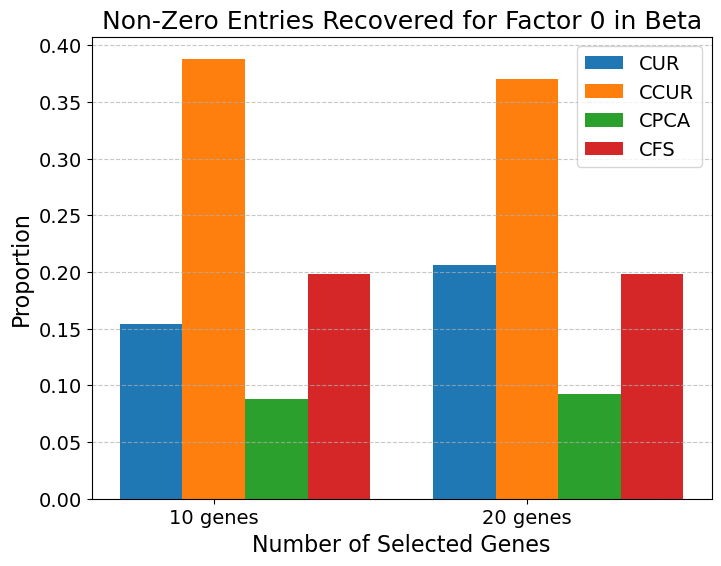

In [9]:
import matplotlib.pyplot as plt
factor = 0

top_selected_list = [10, 20]
methods = ["CUR", "CCUR", "CPCA", "CFS"]
x = np.arange(len(top_selected_list))  
width = 0.2  

plt.figure(figsize=(8, 6))  
for i, method in enumerate(methods):
    y = [averages[factor][method][ts] for ts in top_selected_list]
    plt.bar(x + i * width, y, width, label=method)

plt.xticks(x + width, [f"{ts} genes" for ts in top_selected_list], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Proportion", fontsize=16)
plt.xlabel("Number of Selected Genes", fontsize=16)
plt.title(f"Non-Zero Entries Recovered for Factor {factor} in Beta", fontsize=18)
plt.legend(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [11]:
def run_simulation(n_values, p=1000, f=3, k=10, top_selected=10, num_simulations=100):
    results = {"CUR": [], "CCUR": []}

    for n in n_values:
        cur_averages = []
        ccur_averages = []

        for _ in range(num_simulations):
            # Generate data
            background, foreground, beta, alpha, W, V = generate_data(n, p, f)

            ccur_cols = relative_importance(foreground, background, k, top_selected)[0]
            ccur_rows = deterministic_cur(foreground[:, ccur_cols], k, top_selected)[4]
            row_means = np.mean(np.abs(W[ccur_rows, 0]))  # Mean of each selected row
            ccur_averages.append(row_means)

            cur_rows = deterministic_cur(foreground, k, top_selected)[4]
            row_means = np.mean(np.abs(W[cur_rows, 0]))  # Mean of each selected row
            cur_averages.append(row_means)

        # Store averages for this n
        results["CUR"].append(np.mean(cur_averages))
        results["CCUR"].append(np.mean(ccur_averages))

    return results



In [ ]:
np.random.seed(42) 

n_values = [100,250,500,1000]

results = run_simulation(n_values)



In [ ]:
plt.figure(figsize=(8, 6))  
plt.plot(n_values, results["CUR"], label="CUR", marker="o", markersize=8)
plt.plot(n_values, results["CCUR"], label="CCUR", marker="s", markersize=8)
plt.xlabel("Foreground and Background Size (n = m)", fontsize=16)
plt.ylabel("Value", fontsize=16)
plt.title("Average Value for Selected Rows in Factor 0 in W", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
